In [1]:
import os
import glob
import math
import json

import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from nets import blaze_palm

from utils.data_generator import DataGenerator
from utils.encoder import center_to_corner, corner_to_center, match
from utils.anchors_generator import AnchorsGenerator
from utils.loss_function import SSDLoss, smooth_l1_loss, binary_focal_loss_fixed
from utils.anchor_config import AnchorsConfig
from utils.decoder import preprocess

## Test Create Model

In [2]:
model = blaze_palm.build_blaze_palm_model()

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
depthwise_conv2d (DepthwiseConv (None, 128, 128, 32) 320         activation[0][0]                 
______________________________________________________________________________________________

In [4]:
model.layers[-1].output_shape

[(None, None, 19)]

## Test Anchor Generator

**SSD Default Anchors**

In [5]:
anchor_config = AnchorsConfig(aspect_ratios=[1, 0.5, 2], fixed_anchor_size=False)
anchor_generator = AnchorsGenerator(anchor_config)
anchors = anchor_generator.generate()
anchors = np.array([[anchor.x_center,anchor.y_center, anchor.w, anchor.h] for anchor in anchors])*256

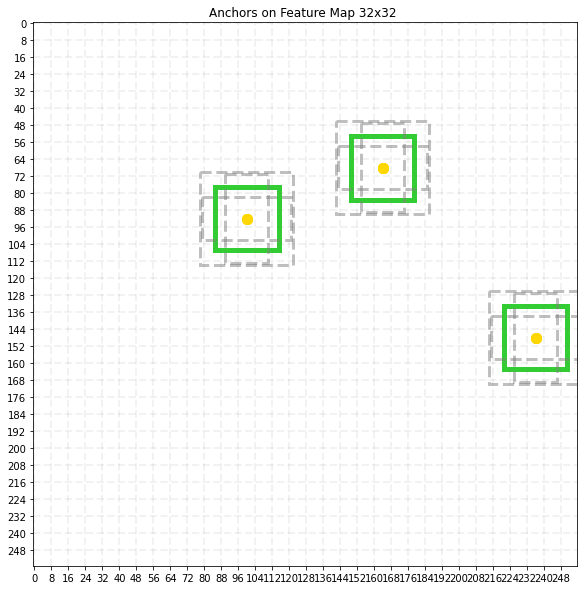

In [6]:
x = 0
padding = 0
color = ['limegreen', 'gray', 'gray', 'gray']
width = [5, 3, 3, 3]
style = ['-', '--', '--', '--']
alpha = [1, 0.5, 0.5, 0.5]
feature_map = {0:8, 4:16, 8:32, 12:32, 16:32}
c1, c2, c3, c4 = pd.DataFrame(anchors)[2].unique()[x:x+4]
condition = (
(pd.DataFrame(anchors)[2] == c1) | \
(pd.DataFrame(anchors)[2] == c2) | \
(pd.DataFrame(anchors)[2] == c3) | \
(pd.DataFrame(anchors)[2] == c4) |\
(pd.DataFrame(anchors)[3] == c1) | \
(pd.DataFrame(anchors)[3] == c2) | \
(pd.DataFrame(anchors)[3] == c3) | \
(pd.DataFrame(anchors)[3] == c4))
show_anchors = np.array(pd.DataFrame(anchors)[condition])


plt.figure(figsize=(10, 10))
plt.title("Anchors on Feature Map %sx%s "% (256//feature_map[x], 256//feature_map[x]))
result_image = np.pad(np.ones((256,256,3))*255, ((padding, padding), (padding, padding), (0, 0)), mode='constant')
for show in range(3):
    random_int = np.random.randint(len(show_anchors)//4)*4
    for i, bbox in enumerate(show_anchors[random_int:random_int+4]):
        cx, cy, w, h = bbox
        cx += padding
        cy += padding
        x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=width[i], 
                                 edgecolor=color[i],
                                 linestyle=style[i],
                                 alpha=alpha[i],
                                 facecolor="none")
        plt.gca().add_patch(rect)
        plt.scatter(cx, cy, color='gold', s=100)

rect = patches.Rectangle((padding, padding), 
                         result_image.shape[1], 
                         result_image.shape[0],
                         linewidth=0,
                         edgecolor=color[i], 
                         linestyle=style[i], 
                         facecolor="none")
plt.gca().add_patch(rect)
plt.xticks(np.arange(padding, 257+padding, feature_map[x]))
plt.yticks(np.arange(padding, 257+padding, feature_map[x]))
plt.grid(linestyle='--', linewidth=2, c='grey', alpha=0.1)
plt.imshow(result_image.astype('int'))
plt.show()

**BlazePalm Anchors**

In [7]:
anchor_config = AnchorsConfig(fixed_anchor_size=False)
anchor_generator = AnchorsGenerator(anchor_config)
anchors = anchor_generator.generate()
anchors = np.array([[anchor.x_center,anchor.y_center, anchor.w, anchor.h] for anchor in anchors])*256

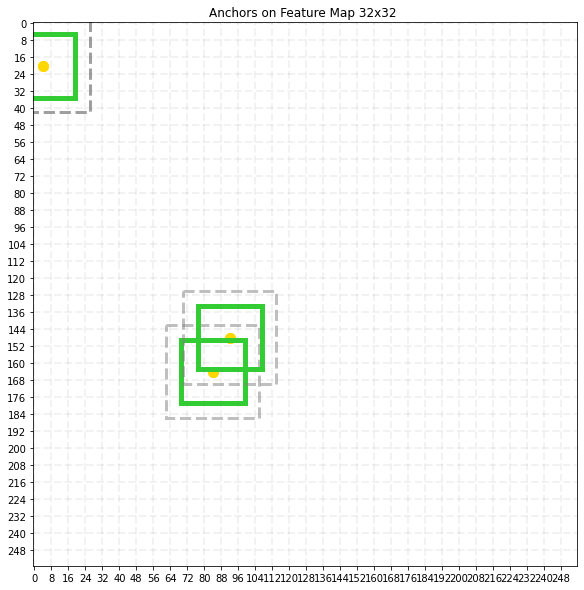

In [8]:
x = 0
color = ['limegreen', 'gray', 'gray', 'gray']
width = [5, 3, 3, 3]
style = ['-', '--', '--', '--']
alpha = [1, 0.5, 0.5, 0.5]
show_anchors = np.array(pd.DataFrame(anchors))


plt.figure(figsize=(10, 10))
plt.title("Anchors on Feature Map %sx%s "% (256//feature_map[x], 256//feature_map[x]))
result_image = np.ones((256,256,3))*255
for show in range(3):
    random_int = np.random.randint(len(show_anchors)//2)*2
    for i, bbox in enumerate(show_anchors[random_int:random_int+2]):
        cx, cy, w, h = bbox
        x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=width[i], 
                                 edgecolor=color[i],
                                 linestyle=style[i],
                                 alpha=alpha[i],
                                 facecolor="none")
        plt.gca().add_patch(rect)
        plt.scatter(cx, cy, color='gold', s=100)
plt.gca().add_patch(rect)
plt.xticks(np.arange(0, 257, feature_map[x]))
plt.yticks(np.arange(0, 257, feature_map[x]))
plt.grid(linestyle='--', linewidth=2, c='grey', alpha=0.1)
plt.imshow(result_image.astype('int'))
plt.show()

## Test Match and Encode for Annotation

In [9]:
anchor_config = AnchorsConfig(fixed_anchor_size=False)
anchor_generator = AnchorsGenerator(anchor_config)
anchors = anchor_generator.generate()
anchors = np.array([[anchor.x_center,anchor.y_center, anchor.w, anchor.h] for anchor in anchors])

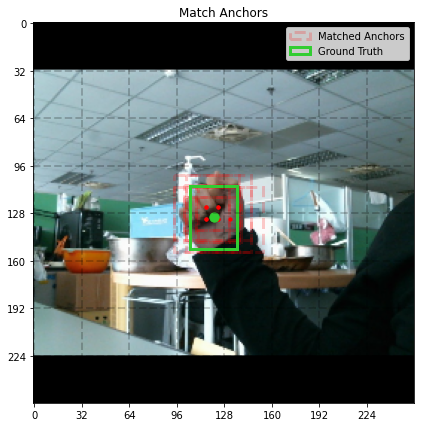

In [10]:
anno_path = np.random.choice(glob.glob(os.path.join('dataset', 'annotation', '*.json')))
img_path = anno_path.replace('annotation', 'image').replace('.json', '.jpg')
with open(anno_path, 'r') as json_file:
    annotation = json.load(json_file)
for i in range(len(annotation)):
    temp_loc = np.zeros((len(annotation), 18))
    temp_label = np.zeros((len(annotation), 1))
    temp_label[i] = float(annotation[i]['label'])
    temp_loc[i] = np.concatenate([annotation[i]['bounding_box'], annotation[i]['key_points']])
annotation = [temp_label, temp_loc]
conf, loc = match(annotation, anchors, match_threshold=0.5)


color = ['limegreen', 'r']
width = [3, 3]
style = ['-', '--']
alpha = [1, 0.2]


plt.figure(figsize=(7, 7))
plt.title("Match Anchors")
result_image = preprocess(cv2.imread(img_path), normalize=False)[0]
for i, bbox in enumerate(anchors[np.where(conf != 0)[0]]*256):
    cx, cy, w, h = bbox
    x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)    
    if i == 0:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[1], ec=color[1], ls=style[1], alpha=alpha[1], facecolor="none", label='Matched Anchors')
    else:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[1], ec=color[1], ls=style[1], alpha=alpha[1], facecolor="none")
    plt.gca().add_patch(rect)
    plt.scatter(cx, cy, color=color[1], s=10)

for i in range(len(annotation[1])):
    x1, y1, x2, y2 = annotation[1][:,:4][i]*256
    if i == 0:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[0], ec=color[0], ls=style[0], alpha=alpha[0], facecolor="none", label='Ground Truth')
    else:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[0], ec=color[0], ls=style[0], alpha=alpha[0], facecolor="none")
    plt.gca().add_patch(rect)
    plt.scatter((x2+x1)/2, (y2+y1)/2, color=color[0], s=87)

plt.xticks(np.arange(0, 257, 32))
plt.yticks(np.arange(0, 257, 32))
plt.grid(linestyle='--', linewidth=2, c='k', alpha=0.2)
plt.legend()
plt.imshow(result_image)
plt.show()

In [11]:
# for anno_path in glob.glob(os.path.join('dataset', 'annotation', '*.json')):
#     img_path = anno_path.replace('annotation', 'image').replace('.json', '.jpg')
#     with open(anno_path, 'r') as json_file:
#         annotation = json.load(json_file)
#     for i in range(len(annotation)):
#         temp_loc = np.zeros((len(annotation), 18))
#         temp_label = np.zeros((len(annotation), 1))
#         temp_label[i] = float(annotation[i]['label'])
#         temp_loc[i] = np.concatenate([annotation[i]['bounding_box'], annotation[i]['key_points']])
#     annotation = [temp_label, temp_loc]

In [12]:
# os.remove(anno_path)
# os.remove(img_path)

## Test Data Generator

In [13]:
ssd_loss = SSDLoss(alpha=1./256.)

In [14]:
train_data_generator = DataGenerator(image_dir=os.path.join('dataset', 'image'), 
                                     annotation_dir=os.path.join('dataset', 'annotation'),
                                     batch_size=32)

In [15]:
batch = train_data_generator.__getitem__(0)
y_pred = model.predict(batch[0])
y_true = batch[1]
ssd_loss.compute_loss(y_true, y_true)

<tf.Tensor: id=4161, shape=(32,), dtype=float32, numpy=
array([0.13356014, 0.00488138, 0.00542376, 0.00488138, 0.00433901,
       0.00433901, 0.00433901, 0.00379663, 0.00379663, 0.00596613,
       0.00379663, 0.00433901, 0.00433901, 0.00433901, 0.00379663,
       0.00488138, 0.00433901, 0.00108475, 0.00162713, 0.00325425,
       0.00433901, 0.00433901, 0.00488138, 0.00488138, 0.00325425,
       0.00488138, 0.0021695 , 0.00108475, 0.00433901, 0.00542376,
       0.00488138, 0.0021695 ], dtype=float32)>

In [16]:
smooth_l1_loss(y_true[:,:,1:], y_true[:,:,1:])

<tf.Tensor: id=4171, shape=(32, 2944), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

In [17]:
binary_focal_loss_fixed([0., 1.], [0., 1.])

<tf.Tensor: id=4201, shape=(2,), dtype=float32, numpy=array([0.1299651 , 0.00566451], dtype=float32)>